In [153]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import yfinance as yf
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [148]:
class StockPrediction():
    def __init__(self,stock_symbol="SPY",interval='1d'):
        """Initializes the class, creates the following arguments:
        stock_symbol: Ticker
        interval: period between any sample in the data 
        df: downloaded data
        
        """
        self.stock_symbol = stock_symbol
        self.interval = interval
        self.df = self.download_ticker(self.stock_symbol,self.interval)
        self.train = None # train set from train_test_split
        self.test = None # test set from train_test_split
        self.d= 0

        # baseline model
        self.baseline_history = []
        self.baseline_pred = []
        self.baseline_RMSE = None
        
        # model
        self.model = None
        self.pred = []
        self.history = []
        
               
    def download_ticker(self, ticker, interval):
        """params: 
            ticker: default is SPY
            returned_cols: (list) default is Adj Close
            interval: one of 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo, default is 1d
            returns: df with ticker data index is timeseries"""
        return yf.download(ticker, interval=interval)
    
    def train_test_split(self, col="Adj Close",diff=0, pct_change=False, train_size=.99):
        """Splits dataframe into train and test according to train_size"""
        self.d = diff
        self.original_price = col
        ind_split=int(np.floor(len(self.df.index)*train_size))
        # Train
        self.train= self.df.iloc[:ind_split][col] if self.d==0 else \
            (self.df.iloc[:ind_split][col].diff(self.d).dropna() if not pct_change else \
             self.df.iloc[:ind_split][col].pct_change(self.d).dropna()*100)
        # test
        self.test = self.df.iloc[ind_split:][col] if self.d==0 else \
            (self.df.iloc[ind_split:][col].diff(self.d).dropna() if not pct_change else \
             self.df.iloc[ind_split:][col].pct_change(self.d).dropna()*100)
        print("train, test split success")
            
    def baseline_predict_all(self,p=1,q=1,diff=False):
        self.baseline_pred = []
        self.baseline_history = self.train.to_list()
        
        for t in tqdm(range(len(self.test)),total=len(self.test)):
            bsl_model = ARIMA(self.baseline_history, order = (p, q if not diff else 0 ,q))
            bsl_fit = bsl_model.fit()
            self.baseline_pred.append(bsl_fit.forecast()[0])
            self.baseline_history.append(self.test[t])
        self.baseline_RMSE = np.sqrt(((self.test.to_numpy() - np.array(self.baseline_pred))**2).sum()/len(self.test.index))
        
    def baseline_predict(self, scope=1, p=4, q=1):
        baseline_model = ARIMA(pd.concat([self.train,self.test]), order=(p, q if not diff else 0, q))
        bsl_fit = baseline_model.fit()
        return pd.Series(bsl_fit.forecast(steps = scope))
    
    def plot_baseline_performance(self):
        plt.figure(figsize=(12,8))
        ax = self.test.plot(label="y_true")
        pd.Series(self.baseline_pred,index=self.test.index).plot(label="y_pred_baseline", ax = ax)
        ax.grid(True, which="both")
        ax.legend()
        ax.set_title(f"RMSE_Baseline: {self.baseline_RMSE:.4f}")
        
        
    def exp_predict_all(self):
        """Makes exponantial smoothing predictions for all test set, adds it as a new attribute: self.exp_preds"""
        exp_pred = pd.Series()
        exp_history = self.train.to_list()

        for t in range(len(spy.test)):
            exp_model = SimpleExpSmoothing(exp_history,initialization_method='estimated')
            exp_fit = exp_model.fit()
            exp_pred[self.test.index[t]]=exp_fit.forecast()[0]
            exp_history.append(self.test[t])
        self.exp_preds=exp_pred
        self.exp_RMSE=mean_squared_error(self.test,self.exp_preds,squared=False)        
        
    def exp_predict(self):
        """Makes Unique prediction for the next period"""
        exp_model = SimpleExpSmoothing(self.df['Adj Close'],initialization_method='estmiated').fit()
        return pd.Series(exp_model.forecast())
    
    def profiling(self,cols=["Adj Close"]):
        """Automatic EDA"""
        # head
        print("The head of the DataFrame:")
        display(self.df.head())
        print("\n")
        
        # shape
        print("The shape of the DataFrame:")
        display(self.df.shape)
        print("\n")
        
        # index
        print("The time stamp for each record:")
        display(self.df.index)
        print("\n")
        
        # plot the distribution of the day
        print("The distribution of the weekday recorded:")
        sns.countplot(x=self.df.index.strftime('%A'))
        plt.show()
        print("\n")
        
        # gap
        print("The start date and the current end date for the data:")
        display(self.df.index[0],self.df.index[-1])
        print("\n")
        
        # nan check
        print("If there is missing values in the data:")
        display(self.df.isna().sum())
        print("\n")
        
        # describe
        print("Describe the time series:")
        display(self.df.describe())
        print("\n")
        
        for col in cols:
            # plot time series values
            print("Plot the time series:")
            plt.figure(figsize=(12,8))
            self.plot(col)
            plt.title = f"{col} Price"
            plt.show()
            
            # plot diff one day
            print("Plot the change in the time series:")
            plt.figure(figsize=(12,8))
            self.df[col].diff().plot()
            plt.title = f"{col} Price Change"
            plt.show()
            # plot diff acf
            print(f"Plot the Auto-Correlation Function of {col} Price Change:")
            self.plot_acf(col)
            plt.show()
            # plot diff pacf
            print(f"Plot the Partial Auto-Correlation Function of {col} Price Change:")
            self.plot_pacf(col)
            plt.show()
            
    def plot(self,col="Adj Close"):
        self.df[col].plot()
        
    def plot_acf(self,col="Adj Close"):
        plot_acf(self.df[col].diff().dropna())
        
    def plot_pacf(self,col="Adj Close"):
        plot_pacf(self.df[col].diff().dropna())
    

In [256]:
spy=StockPrediction()

[*********************100%***********************]  1 of 1 completed


In [257]:
spy.train_test_split(train_size=.8)

train, test split success


In [265]:
spy.test.iloc[-1]/spy.test.iloc[0]

1.928292072912383

In [258]:
spy.exp_predict_all()

In [268]:
class Invest_shorten():
    def __init__(self,true_adj_close,preds):
        """The class receives the true proces of the stock and the predictions of prices"""
        self.daily_table=pd.DataFrame() #Initializes the table
        self.daily_table['Adj_close']=true_adj_close #Adds the true prices
        self.daily_table['preds']=preds #Adds predictions
        self.daily_table['pred_rec']=(self.daily_table['Adj_close'].shift(1)<self.daily_table.preds).astype(int) # Makes recommandation based on predictions
        self.daily_table['profit_day']=self.daily_table['Adj_close'].pct_change()  #Checks for stocks profit on this day
        self.daily_table['profit_pred']=np.select([self.daily_table.pred_rec==1,self.daily_table.pred_rec==0],[self.daily_table.profit_day,0])+1 #Constructs system profit based on stock profit and recommandation
        self.daily_table.iloc[0,-1]=self.daily_table['Adj_close'].iloc[0] #Initialises the initial money as initial stock price
        self.daily_table['money_end_day']=np.cumprod(self.daily_table.profit_pred)
        
    def plot_money_end_day_evolution(self):
        """Plots the total amount of money of stock vs prediction based"""
        plt.figure(figsize=(13,10))
        self.daily_table['Adj_close'].plot(label='True prices')
        self.daily_table.money_end_day.plot(label='Preds')
        plt.legend();
    
    def plot_daily_pct_change(self):
        plt.figure(figsize=(13,10))
        self.daily_table.profit_day.plot(label='true changes')
        plt.plot(self.daily_table.profit_pred[1:]-1,label='Preds')
        plt.legend();
    
    def make_summary_table(self):
        summary=pd.DataFrame()
        summary['RMSE']=[mean_squared_error(self.daily_table.Adj_close,self.daily_table.preds,squared=False)]
        summary['Stock_return']=[(self.daily_table.Adj_close.iloc[-1]/self.daily_table.Adj_close.iloc[0])-1]
        summary['System_return']=[(self.daily_table.money_end_day.iloc[-1]/self.daily_table.money_end_day[0])-1]
        true_recommandations=(self.daily_table['Adj_close'].shift(1)<self.daily_table['Adj_close']).astype(int)
        summary['Recommandation_accuracy']=[accuracy_score(true_recommandations,self.daily_table.pred_rec)]
        return summary

In [273]:
money_from_exp=Invest_shorten(spy.test,spy.exp_preds)

In [274]:
money_from_exp.make_summary_table()

,RMSE,Stock_return,System_return,Recommandation_accuracy
0,3.645434,0.928292,0.592565,0.513842


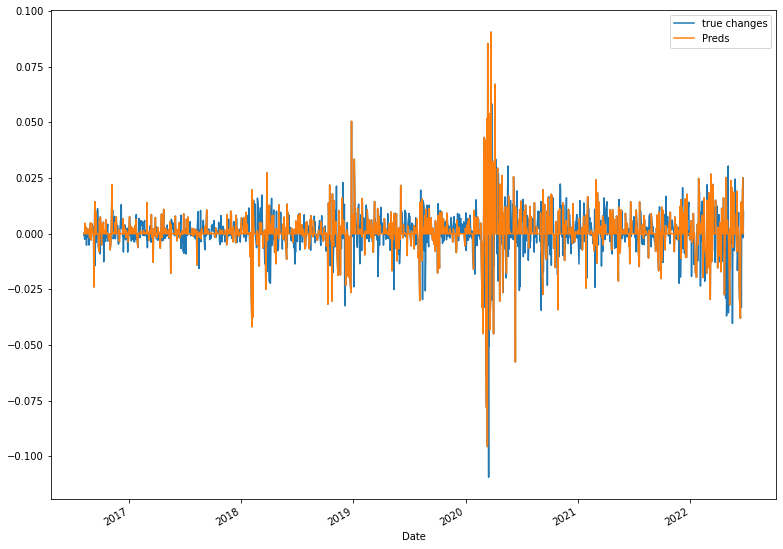

In [275]:
money_from_exp.plot_daily_pct_change()

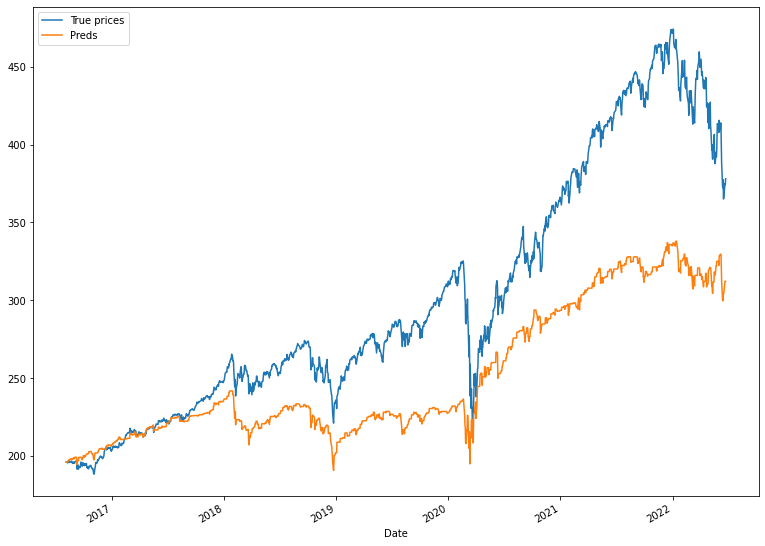

In [276]:
money_from_exp.plot_money_end_day_evolution()

In [277]:
spy.baseline_predict_all()

  0%|          | 0/1481 [00:00<?, ?it/s]

In [279]:
money_baseline=Invest_shorten(spy.test,spy.baseline_pred)

In [281]:
money_baseline.make_summary_table()

,RMSE,Stock_return,System_return,Recommandation_accuracy
0,3.654143,0.928292,0.370013,0.497637


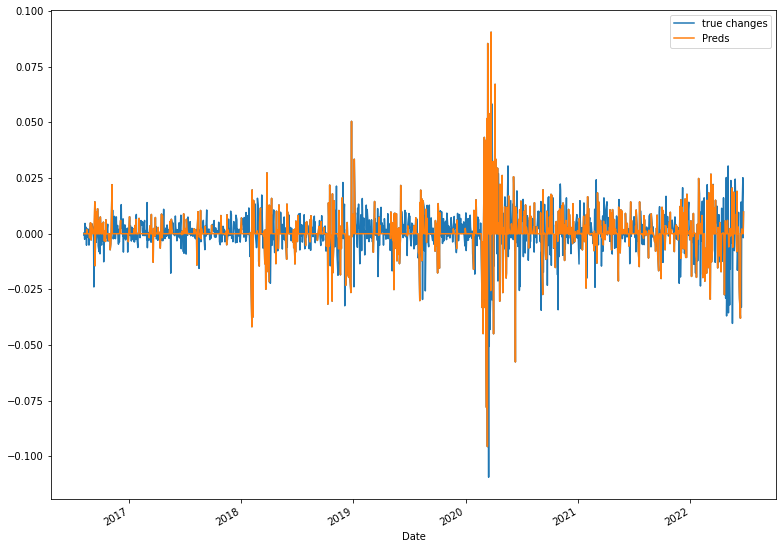

In [282]:
money_baseline.plot_daily_pct_change()

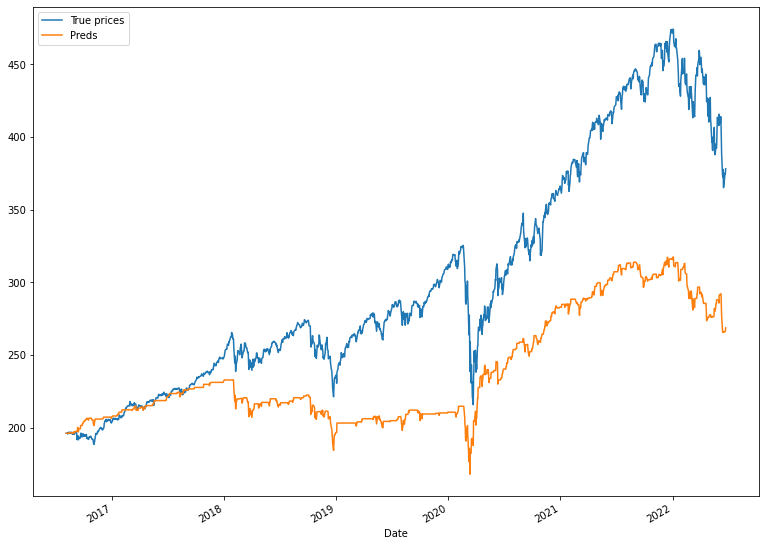

In [283]:
money_baseline.plot_money_end_day_evolution()